# Bienvenue sur le meilleur notebook

In [352]:
conda install pydot

Solving environment: done

## Package Plan ##

  environment location: /Users/Nathan/opt/anaconda3

  added / updated specs:
    - pydot


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.2                |   py37hecd8cb5_0         2.9 MB
    graphviz-2.40.1            |       hefbbd9a_2         6.3 MB
    pydot-1.4.1                |           py37_0          42 KB
    ------------------------------------------------------------
                                           Total:         9.2 MB

The following NEW packages will be INSTALLED:

  graphviz           pkgs/main/osx-64::graphviz-2.40.1-hefbbd9a_2
  pydot              pkgs/main/osx-64::pydot-1.4.1-py37_0

The following packages will be UPDATED:

  conda                                        4.8.5-py37_0 --> 4.9.2-py37hecd8cb5_0



pydot-1.4.1          | 42 KB     | ##################################### | 100% 
graphviz-

In [348]:
import numpy as np
from matplotlib import pyplot as plt
import math
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

# Calculs de bornes primales

In [39]:
def computeCost(p,d,w,order):
    t=0
    cost=0
    for idx in order:
        t += p[idx]
        cost += max(0,(t-d[idx])*w[idx])
    return cost

In [86]:
def getPrimal_0(p,d,w):
    sortedTasks=np.argsort(d)
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,list(sortedTasks))

In [87]:
def getPrimal_1(p,d,w):
    sortedTasks=(np.argsort((np.array(d)-np.array(p))*np.array(w)))[::-1]
    cost=computeCost(p,d,w,sortedTasks)
    return(cost,list(sortedTasks))

In [88]:
def getPrimal_2(p,d,w):
    tasksLeft=[int(i) for i in range(len(p))]
    order=[]
    while len(tasksLeft)!= 0:
        time=np.sum(np.array(p)[tasksLeft])
        penalities=(time-np.array(d)[tasksLeft])*np.array(w)[tasksLeft]
        sortedTasks=np.argsort(penalities)
        order.append(tasksLeft[sortedTasks[0]])
        tasksLeft.pop(sortedTasks[0])
    order.reverse()
    cost = computeCost(p,d,w,order)
    return(cost,order)

## Test des différentes méthodes : 

In [91]:
w=[4,5,3,5]
d=[16,26,25,27]
p=[12,8,15,9]
print("Classement par ordre croissant des dates d'usinage au plus tard :\n",getPrimal_0(p,d,w))
print("Classement par ordre décroissant des (d-p)*w : \n",getPrimal_1(p,d,w))
print("Classement en mettant en dernière position disponible l'élémen non traité donnant lieu à la plus petite pénalité de retard : \n",getPrimal_2(p,d,w))

Classement par ordre croissant des dates d'usinage au plus tard :
 (136, [0, 2, 1, 3])
Classement par ordre décroissant des (d-p)*w : 
 (133, [3, 1, 2, 0])
Classement en mettant en dernière position disponible l'élémen non traité donnant lieu à la plus petite pénalité de retard : 
 (67, [0, 1, 3, 2])


# Calculs de borne dual

In [138]:
def getDual_0(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    return dual

In [139]:
def getDual_1(p,d,w,visited):
    dual=0
    time=0
    notVisited=list(range(len(p)))
    for i in visited:
        retard=((p[i]+time)-d[i])
        dual+=retard*w[i]*(retard>0)
        time+=p[i]
        notVisited.remove(i)
        
    for j in notVisited:
        retard=(p[j]+time)-d[j]
        dual+=retard*w[j]*(retard>0)
    return dual

In [140]:
def getDual_2(p,d,w,visited):
    dual=0
    time=np.sum(p)

    for i in visited:
        retard=(time-d[i])
        dual+=retard*w[i]*(retard>0)
        time-=p[i]
        
    return dual

## Test des méthodes : 

In [141]:
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : \n",getDual_0(p,d,w,[0,1]))
print("Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : \n",getDual_1(p,d,w,[0,1]))

Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces : 
 0
Si on a fixé l'ordre de k pièces on calcule les pénalités de retard de ces k pièces et on ajoute les pénalités des autres pièces en supposant qu'elles sont en (k+1)ème position : 
 40


# Règles d'exploration

In [286]:
def exploration_0(Queue,Tree,UB):
    return(Queue[0])

def exploration_1(Queue,Tree,UB):
    bestNode = None
    bestLB = -math.inf
    for i in range(len(Queue)):
        if Tree[Queue[i]].lb > bestLB and Tree[Queue[i]].lb < UB:
            bestLB = Tree[Queue[i]].lb
            bestNode = i
    return(Queue[i])

# Implementation 

In [424]:
class Node:
    def __init__(self, idx, parent, children, lb, visited):
        self.idx=idx
        self.parent = parent
        self.children = children
        self.lb = lb
        self.visited = visited
    def __str__(self):
        return "Parent : " +str(self.parent)+"\n Children : "+str(self.children) + "\n lb : "+str(self.lb) + "\n visited : "+str(self.visited)

In [505]:
def branch_and_bound(p,d,w,byLast,getPrimal,getDual,exploration,steps):

    Tasks = list(range(len(p)))
    Tree = [] # list of all nodes created (a list of Node objects)
    Queue = [] # list of nodes to process (a list of integers with the index of nodes to process in the Tree)
    UB = 10000000 # set the upper bound to a sufficiently large number
    LB = 0 # set the lower bound to a sufficiently small number 
    
    UB,currentOrder = getPrimal(p,d,w)
    if steps:
        print("First UB : ", UB)
    
    root = Node(0, None, [], 0, []) # at the root node no variables are fixed 
    Tree.append(root) # start the tree with the root node
    Queue.append(0) # start the list of nodes to process with the root node
    
    #continue processing nodes until the queue is empty
    
    nbIterations = 0
    
    while Queue!=[]:
        
        # process the first node in the queue

        currentIndex = exploration(Queue,Tree,UB)
        currentNode = Tree[currentIndex]
        nbIterations +=1
        
        if steps:
            print("##################################")
            print("Current Node : {}\n".format(currentIndex),currentNode )
        
        if len(currentNode.visited) == len(p):
            order = currentNode.visited.copy()
            if byLast:
                order.reverse()
            solutionCost = computeCost(p,d,w,order)
            if solutionCost <= UB:
                bestNode=currentNode
                UB = solutionCost
                currentOrder=order
                
        if currentNode.lb < UB:
            for nextTask in (set(Tasks)-set(currentNode.visited)):
                
                nextVisited = currentNode.visited.copy()
                nextVisited.append(nextTask)
                nextLb = getDual(p,d,w, nextVisited)
                
                newNode = Node(len(Tree),currentNode, [], nextLb,nextVisited)
                Tree.append(newNode)
                Queue.append(len(Tree)-1)
                currentNode.children.append(newNode)
        else:
            if steps:
                print("Prune : ", currentIndex)
        
        # Calculate the current LB as the maximum of all the upper bounds among the active nodes
        currentLB = -math.inf
        for node in Tree:
            if node.lb > currentLB and node.lb <= UB:
                currentLB = node.lb
        
        # Update the LB if the current LB is better
        if currentLB >= LB:
            LB = currentLB
        
        # Display the current upper and lower bounds    
        if steps:
            print("LB= ",LB," UB= ", UB)
        # When the processing of the node is completed remove the node from the queue     
        Queue.remove(currentIndex)

    # return the  solution
    print("Number of iterations : ", nbIterations)
        
    
    return UB, currentOrder,nbIterations,Tree,bestNode

# Generation d'instances du problème

In [506]:
def genInstancies(n):
    p=np.random.randint(1,25,n)
    d=np.random.randint(3,29,n)
    w=np.random.randint(10,120,n)
    return(p,d,w)

# Test branch and bound

## Avec instances du td

In [507]:
w=[4,5,3,5]
d=[16,26,25,27]
p=[12,8,15,9]

In [508]:
Tree=branch_and_bound(p,d,w,False,getPrimal_1,getDual_1,exploration_0,steps=False)[3]

Number of iterations :  48


# Visualisation du parcours de l'arbre de branchement

In [509]:
def showTree(Tree,currentOrder,bestNode):
    parent=[]
    index=[]
    for node in Tree:
        index.append(node.idx)
        parent.append(node.parent)
    dico=dict(zip(index,parent))
    graph=nx.Graph()
    graph.add_nodes_from(dico.keys())
    for k in dico.keys():
        if k!=0:
            graph.add_edge(k,dico[k])
    
    
    order=[bestNode.idx]
    node=bestNode
    for i in range(len(currentOrder)):
        node=node.parent
        order.append(node.idx)
    order.append(0)
    
    path = set(zip(order[:-1], order[1:]))
    
    edge_colors = dict()
    for edge in graph.edges():
        if edge in path:
            edge_colors[edge] = 'red'
            continue
        else:
            edge_colors[edge] = 'lightblue'

    pos = graphviz_layout(graph, prog="dot")
    plt.figure(figsize=(12,8))

    nx.draw(graph, pos,with_labels=True,node_size=800,node_color='lightblue',alpha=0.9,linewidth=40,edge_color=edge_colors.values())
    plt.show()

Number of iterations :  48
[0, 1, 3, 2]
{(0, 1), (3, 2), (1, 3)}


/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/Nathan/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


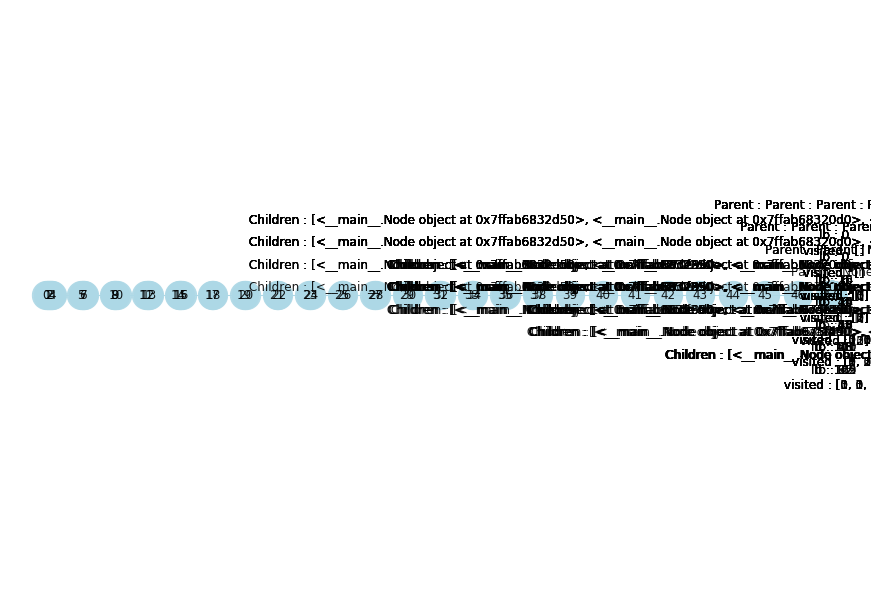

In [510]:
UB, currentOrder,nbIterations,Tree,idx=branch_and_bound(p,d,w,False,getPrimal_1,getDual_1,exploration_0,steps=False)
print(currentOrder)
print(set(zip(currentOrder[:-1], currentOrder[1:])))
showTree(Tree,currentOrder,idx)

In [316]:
branch_and_bound(p,d,w,True,getPrimal_2,getDual_2,exploration_0,steps=False)

Number of iterations :  8


(67, [0, 1, 3, 2], 8)

In [317]:
branch_and_bound(p,d,w,True,getPrimal_2,getDual_2,exploration_1,steps=False)

Number of iterations :  8


(67, [0, 1, 3, 2], 8)

In [318]:
branch_and_bound(p,d,w,False,getPrimal_0,getDual_1,exploration_1,steps=False)

Number of iterations :  37


(67, [0, 1, 3, 2], 37)

In [319]:
branch_and_bound(p,d,w,False,getPrimal_0,getDual_1,exploration_0,steps=False)

Number of iterations :  52


(67, [0, 1, 3, 2], 52)

## Avec instances aléatoires

In [325]:
p,d,w=genInstancies(10)
branch_and_bound(p,d,w,True,getPrimal_2,getDual_2,exploration_1,steps=False)

KeyboardInterrupt: 